In [384]:
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from strategy import Strategy

# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install numpy_ringbuffer sklearn

from sklearn.decomposition import PCA

In [2]:
currencies = ['usd', 'btc', 'eth', 'ltc', 'xrp']
pairs = [c + '_usd' for c in currencies if c != 'usd']
volume_keys = [c + '_tx_volume' for c in currencies if c != 'usd']

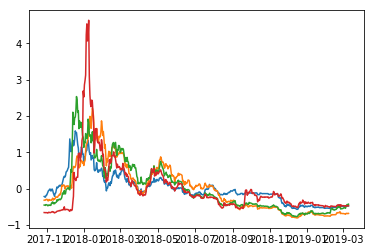

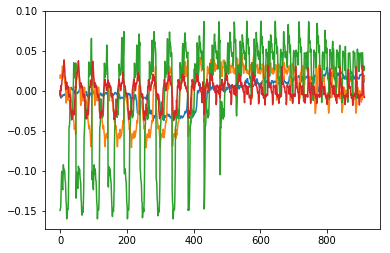

In [16]:
def prep_data(file):
    data = pickle.load(open(file, 'rb'))
    dates = [x['date'] for x in data]
    prices = [{k:v for k,v in x.items() if k in pairs} for x in data]
    volumes = [{(k.partition('_')[0] + '_usd'):v for k,v in x.items() if k in volume_keys} for x in data]
    return { 'prices': pd.DataFrame(prices, index = dates), 'volumes': pd.DataFrame(volumes, index = dates)}

def reduce_data(data, group_size):
    '''Averages prices, sums volumes'''
    prices = data['prices'].groupby(np.arange(len(data['prices']))//group_size).mean()
    volumes = data['volumes'].groupby(np.arange(len(data['volumes']))//group_size).sum()
    return { 'prices': prices, 'volumes': volumes }

def viz_data(data):
    '''Only plots prices for now'''
    plt.plot(data['prices'] / data['prices'].mean() - 1)
    plt.show()

def data_currencies(data):
    currencies = ['usd']
    for pair in data['prices'].columns:
        currencies.append(pair.partition('_')[0])
    return currencies

data = prep_data('data.p')
viz_data(data)
data_15min = reduce_data(prep_data('data-minute.p'), 15)
viz_data(data_15min)

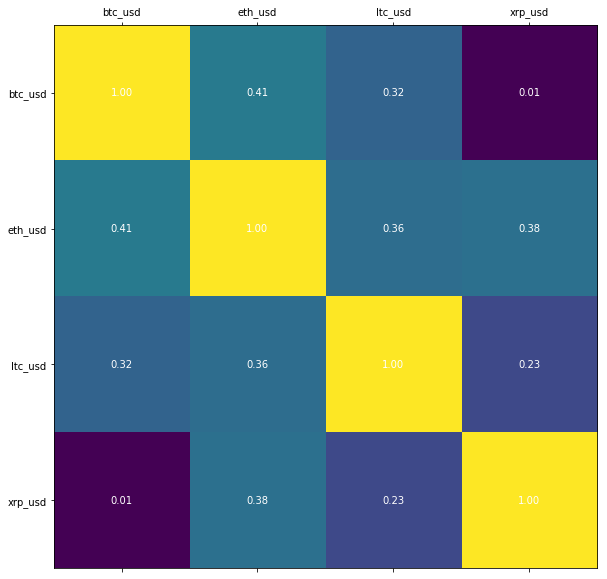

In [8]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df['prices'].corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    # Loop over data dimensions and create text annotations.
    for i in range(len(corr.columns)):
        for j in range(len(corr.columns)):
            ax.text(j, i, '{:0.2f}'.format(corr.iloc[i, j]), ha="center", va="center", color="w")

plot_corr(data_15min)

In [559]:
def execute_orders(fees, prices, balances, orders):
    for (pair, size) in orders.items():
        # hacky...
        currency = pair.partition("_")[0]
        balances['usd'] -= size * prices[pair]
        balances[currency] += size

def pnl(balances, prices):
    usd = 0
    for (currency, qty) in balances.items():
        if currency == 'usd':
            usd += qty
        else:
            pair = currency + '_usd'
            usd += qty * prices[pair]
    return usd


def market_risk(diff_stddevs, pcs, balances):
    '''sqrt(sum(position * var(currency) * pc1[currency]))'''
    balances = pd.DataFrame([{(k+'_usd'):v for k,v in balances.items() if k != 'usd'}])
    risk = np.abs(pcs.values.dot((balances * diff_stddevs).values.T))
    return np.linalg.norm(risk) + 1

def evaluate(strategy, data, fees = 0):
    '''data is prices per-day'''
    balances = dict.fromkeys(data_currencies(data), 0)
    dates = []
    pnls = []
    balances_ = []
    balance_values = []
    risks = []
    diff_stddevs = data['prices'].diff().std()
    diff_pca = PCA(n_components=0.997)
    diff_pca.fit(data['prices'].diff().iloc[1:])
    pcs = pd.DataFrame(diff_pca.components_, columns = data['prices'].columns)
    for (date, prices) in data['prices'].iterrows():
        volumes = data['volumes'].loc[date]
        orders = strategy.step(balances, prices, volumes)
        execute_orders(fees, prices, balances, orders)
        current_pnl = pnl(balances, prices)
        def price(currency):
            if currency == 'usd':
                return 1
            return prices[currency + '_usd']
        dates.append(date)
        balances_.append(balances.copy())
        balance_values.append({ c: qty * price(c) for c, qty in balances.items() })
        pnls.append(current_pnl)
        risks.append(market_risk(diff_stddevs, pcs, balances))
    return {
        'P/L': pd.DataFrame(pnls, index=dates, columns=["P/L"]),
        'balances': pd.DataFrame(balances_, index=dates),
        'balance_values': pd.DataFrame(balance_values, index=dates),
        'risks': pd.DataFrame(risks, index=dates, columns=["Market Risk"])
    }

def plot_results(results):
    '''Plots balances (with P/L) and cumulative return on risk (RoR) for the given strategy evaluation
    
    Note: RoRs are per-tick. They are NOT comparable across time scales.'''
    fig, axs = plt.subplots(1,2, figsize=(16, 4))
    results['balance_values'].plot(ax=axs[0])
    results['P/L'].plot(ax=axs[0])
    results['risks'].plot(ax=axs[1])
    axs[1].axhline(0, color='grey')
    plt.show()
    print('Final RoR:')
    print(results['P/L'].iloc[-1, 0] / results['risks'].values.sum())
    print('Final P/L:')
    print(results['P/L'].iloc[-1, 0])
    print('Final balances:')
    print(results['balances'].iloc[-1])

In [ ]:
from strategy import HoldStrategy

plot_results(evaluate(HoldStrategy(), data_15min))

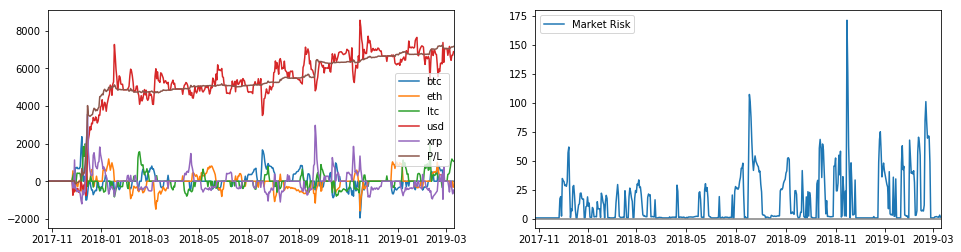

Final RoR:
0.9325728932889745
Final P/L:
7160.543934816866
Final balances:
btc       0.000000
eth      -2.241592
ltc      18.276160
usd    6882.559846
xrp   -1508.650719
Name: 2019-03-10, dtype: float64


In [557]:
from strategy import MovingAverage
from numpy_ringbuffer import RingBuffer
from math import log1p

class StatArb(Strategy):
    def __init__(self, correlation_window_size, movement_half_life, size, min_edge = 0, max_edge = 1e100, correlation_subsampling = 1):
        '''edges are expressed in std deviations of the currency price
        size is $ per std dev. of edge
        '''
        self.moving_prices_history = None 
        self.correlation_window_size = correlation_window_size
        self.min_edge = min_edge
        self.max_edge = max_edge
        self.size = size
        self.correlation_subsampling = correlation_subsampling
        self.moving_prices = MovingAverage(movement_half_life)
        self.moving_volumes = MovingAverage(correlation_window_size)
        
    def desired_balance_value(self, edge):
        '''Returns (expressed in USD) the desired balance for a currency at the given edge from fair'''
        if abs(edge) < self.min_edge:
            return 0
        if abs(edge) >= self.max_edge:
            return 0
        return edge * self.size
        
    def step(self, balances, prices, volumes):
        if self.moving_prices_history is None:
            self.moving_prices_history = RingBuffer(self.correlation_window_size, dtype=(np.float, len(prices.index)))
        self.moving_prices.step(prices)
        self.moving_volumes.step(volumes)
        self.moving_prices_history.append(self.moving_prices.value)
        
        if len(self.moving_prices_history) < self.correlation_window_size:
            return {}
        
        df = pd.DataFrame(np.array(self.moving_prices_history), columns = prices.index)
        
        # subsampling
        df = df.groupby(np.arange(len(df)) // self.correlation_subsampling).mean()
        
        # Calaculates fair movements by averaging correlated movements between all pairs, weighted by r^2 and trading volume
        # Concretely:
        # fair_btc_movement =
        #   (btc_movment * v_btc
        #    + eth_movement * v_eth * r_eth^3 * stddev_btc/stddev_eth
        #    + ltc_movement * v_ltc * r_ltc^3 * stddev_btc/stddev_ltc
        #    + xrp_movement * v_xrp * r_xrp^3 * stddev_btc/stddev_xrp)
        #   / ((1 + r_eth^2 + r_ltc^2 + r_xrp^2)
        #      * total_volume)
        
        # compute fairs, edges
        stddevs = df.std()
        corr = df.corr()
        deltas = prices - df.mean()
        predicted_deltas = (deltas * corr).mul(stddevs, axis=0).div(stddevs, axis=1)
        confidences = corr ** 2
        # integrating volume data does not seem to improve RoR
#         log_volumes = self.moving_volumes.value.apply(log1p)
#         fair_deltas = ((predicted_deltas * confidences).mul(log_volumes, axis=1)).sum(axis=1) / (confidences.sum(axis=1) * log_volumes.sum())
        fair_deltas = (predicted_deltas * confidences).sum(axis=1) / confidences.sum(axis=1)
        edges = (deltas - fair_deltas) / stddevs
        
        # turn fairs into orders
        orders = {}
        for (pair, edge) in edges.items():
            currency = pair.partition('_')[0]
            orders[pair] = self.desired_balance_value(edges[pair]) / prices[pair] - balances[currency]
            
        return orders

plot_results(evaluate(StatArb(correlation_window_size = 32, movement_half_life = 1, size = 1000, min_edge = 0.25), data))

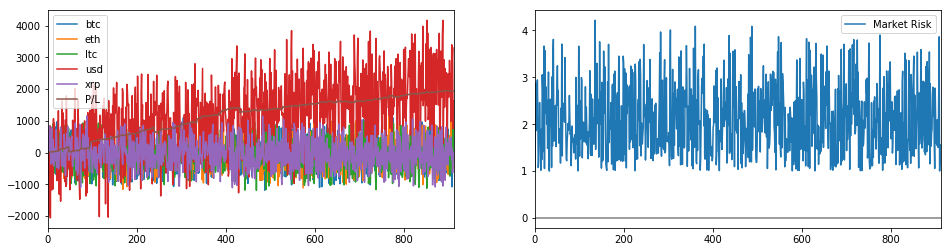

Final RoR:
1.0059211638632624
Final P/L:
1938.2998464010775
Final balances:
btc       0.051554
eth       1.355116
ltc      -1.197464
usd    1620.218828
xrp       0.000000
Name: 912, dtype: float64


In [558]:
plot_results(evaluate(StatArb(correlation_window_size = 3, movement_half_life = 1, size = 1000, min_edge = 0.05), data_15min))

In [ ]:
# wip
from strategy import MovingAverage
from numpy_ringbuffer import RingBuffer›

class BetaTrader(Strategy):
    def __init__(self, correlation_window_size, movement_half_life, size, min_edge = 0, max_edge = 1e100, correlation_subsampling = 1):
        '''edges are expressed in std deviations of the currency price
        size is $ per std dev. of edge
        '''
        self.moving_prices_history = None 
        self.correlation_window_size = correlation_window_size
        self.min_edge = min_edge
        self.max_edge = max_edge
        self.size = size
        self.moving_prices = MovingAverage(movement_half_life)
        self.correlation_subsampling = correlation_subsampling
        
    def desired_balance_value(self, edge):
        '''Returns (expressed in USD) the desired balance for a currency at the given edge from fair'''
        if abs(edge) < self.min_edge:
            return 0
        if abs(edge) >= self.max_edge:
            return 0
        return edge * self.size
        
    def step(self, balances, prices):
        if self.moving_prices_history is None:
            self.moving_prices_history = RingBuffer(self.correlation_window_size, dtype=(np.float, len(prices.index)))
        self.moving_prices.step(prices)
        self.moving_prices_history.append(self.moving_prices.value)
        
        if len(self.moving_prices_history) < self.correlation_window_size:
            return {}
        
        df = pd.DataFrame(np.array(self.moving_prices_history), columns = prices.index)
        
        # subsampling
        df = df.groupby(np.arange(len(df))//self.correlation_subsampling).mean()
        
        # Calaculates fair movements by averaging correlated movements between all pairs, weighted by r^2
        # Concretely:
        # fair_btc_movement =
        #   (btc_movment
        #    + eth_movement * r_eth^3 * stddev_btc/stddev_eth
        #    + ltc_movement * r_ltc^3 * stddev_btc/stddev_ltc
        #    + xrp_movement * r_xrp^3 * stddev_btc/stddev_xrp)
        #   / (1 + r_eth^2 + r_ltc^2 + r_xrp^2)
        
        # compute fairs, edges
        stddevs = df.std()
        corr = df.corr()
        deltas = prices - df.mean()
        predicted_deltas = (deltas * corr).mul(stddevs, axis=0).div(stddevs, axis=1)
        confidences = corr ** 2
        fair_deltas = (predicted_deltas * confidences).sum(axis=1) / confidences.sum(axis=1)
        edges = (deltas - fair_deltas) / stddevs
        
        # turn fairs into orders
        orders = {}
        for (pair, edge) in edges.items():
            currency = pair.partition('_')[0]
            orders[pair] = self.desired_balance_value(edges[pair]) / prices[pair] - balances[currency]
            
        return orders

plot_results(evaluate(StatArb(correlation_window_size = 32, movement_half_life = 3, size = 1000, min_edge = 0.25), data))